# Retina-SEM Preprocessing Demo (Updated)

This notebook reflects the latest preprocessing pipeline:

1. Green-channel extraction + CLAHE
2. Optional resize (square or H×W)
3. Robust FOV mask from outer boundary (background-first circle)
4. Optional **area auto-correct** to normalize FOV area (target ≈ 0.70)
5. Visual sanity checks: original, processed, FOV overlay
6. Quick area-ratio stats for sampled images

**Tip:** Run this on a small sample first, then scale up in `src/preprocess.py`.

In [1]:
from pathlib import Path
import random, math
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Paths & params
DATASET_SPLIT = 'train'   # 'train' | 'val' | 'test'
DATASET_ROOT  = Path('../preprocessed')  # use preprocessed images for quick viewing
RAW_DATASET   = Path('../dataset')       # in case you want to read raw originals
N_SAMPLES     = 6                        # how many images to demo

# FOV settings
SHRINK_PX     = 2
BG_PERCENTILE = 8
MIN_BG_RATIO  = 0.002

# Area auto-correct
AREA_TARGET   = 0.70
AREA_TOL      = 0.05
R_BOUNDS      = (0.33, 0.55)  # min/max radius as fraction of min(H,W) for autocorrect


In [2]:
def to_green_clahe(img_bgr, clip_limit=2.0, tile_grid_size=(8,8)):
    g = img_bgr[:, :, 1]
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    return clahe.apply(g)

def _solid_circle_mask(h, w, cx, cy, r, shrink_px=4):
    Y, X = np.ogrid[:h, :w]
    m = (X - cx)**2 + (Y - cy)**2 <= r*r
    mask = (m.astype(np.uint8) * 255)
    if shrink_px > 0:
        k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2*shrink_px+1, 2*shrink_px+1))
        mask = cv2.erode(mask, k, iterations=1)
    return mask


def _circle_from_distance_transform(fg_mask_u8, r_bounds=(0.33, 0.55), shrink_px=2):
    m = (fg_mask_u8 > 0).astype(np.uint8)
    if m.sum() == 0:
        return None

    dist = cv2.distanceTransform(m, distanceType=cv2.DIST_L2, maskSize=5)
    cy, cx = np.unravel_index(np.argmax(dist), dist.shape)
    r = float(dist[cy, cx])

    # ---- NEW: gentle outward bias (~4%) ----
    r *= 1.04

    h, w = m.shape
    r_min = r_bounds[0] * min(h, w)
    r_max = r_bounds[1] * min(h, w)
    r = int(np.clip(r, r_min, r_max))

    Y, X = np.ogrid[:h, :w]
    circ = ((X - cx)**2 + (Y - cy)**2 <= r*r).astype(np.uint8) * 255

    if shrink_px > 0:
        k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2*shrink_px+1, 2*shrink_px+1))
        circ = cv2.erode(circ, k, iterations=1)
    return circ


def make_fov_mask(proc_img, shrink_px=4, bg_pct=8, min_bg_area_ratio=0.002):
    """
    Robust FOV from outer boundary (background-first), now with distance-transform
    circle to fix center drift:
      A) Estimate background via low-intensity percentile
      B) Keep largest foreground component
      C) Fit maximal inscribed circle (distance transform)  <-- NEW
      D) Hough fallback (rare)
      E) Centered heuristic (very rare)
    Returns uint8 mask {0,255}.
    """
    # ---- prep uint8 ----
    if proc_img.dtype != np.uint8:
        img = cv2.normalize(proc_img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    else:
        img = proc_img.copy()

    h, w = img.shape
    img_area = h * w

    # A) background via percentile
    p = np.percentile(img, bg_pct)
    bg = (img <= p).astype(np.uint8) * 255
    bg = cv2.morphologyEx(bg, cv2.MORPH_CLOSE, np.ones((5,5), np.uint8))
    bg = cv2.morphologyEx(bg, cv2.MORPH_OPEN,  np.ones((3,3), np.uint8))

    bg_ratio = float(bg.sum() // 255) / img_area
    if bg_ratio < min_bg_area_ratio:
        blur = cv2.GaussianBlur(img, (0,0), 3)
        edges = cv2.Canny(blur, 40, 120)
        bg = (edges > 0).astype(np.uint8) * 255

    # B) foreground & largest component
    fg = cv2.bitwise_not(bg)
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats((fg > 0).astype(np.uint8), connectivity=8)
    if num_labels > 1:
        idx = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
        comp = (labels == idx).astype(np.uint8) * 255
    else:
        comp = (fg > 0).astype(np.uint8) * 255

    # C) NEW: maximal inscribed circle (data-driven center)
    dt_circle = _circle_from_distance_transform(comp, r_bounds=(0.33, 0.52), shrink_px=shrink_px)
    if dt_circle is not None:
        return dt_circle

    # D) Hough fallback (edges)
    blur = cv2.GaussianBlur(img, (0,0), 3)
    edges = cv2.Canny(blur, 30, 100)
    r_min = int(0.35 * min(h, w))
    r_max = int(0.49 * min(h, w))
    circles = cv2.HoughCircles(edges, cv2.HOUGH_GRADIENT, dp=1.2,
                               minDist=min(h, w)//2, param1=120, param2=30,
                               minRadius=r_min, maxRadius=r_max)
    if circles is not None:
        x, y, r = np.round(circles[0, 0]).astype(int)
        return _solid_circle_mask(h, w, x, y, r, shrink_px=shrink_px)

    # E) Last resort: centered circle heuristic
    r = int(0.44 * min(h, w))
    return _solid_circle_mask(h, w, w//2, h//2, r, shrink_px=shrink_px)

# (unchanged) area normalization — keeps the improved center, only adjusts radius
def adjust_mask_area(mask_u8, target=0.70, tol=0.05, shrink_px=4, r_bounds=(0.33, 0.52)):
    h, w = mask_u8.shape
    cur_ratio = (mask_u8 > 0).sum() / float(h*w)
    if cur_ratio == 0.0 or abs(cur_ratio - target) <= tol:
        return mask_u8
    # center from moments (fallback to image center)
    m = cv2.moments((mask_u8 > 0).astype(np.uint8))
    cx = int(m["m10"]/m["m00"]) if m["m00"] != 0 else w//2
    cy = int(m["m01"]/m["m00"]) if m["m00"] != 0 else h//2
    # current equivalent radius from area
    r_eq = math.sqrt(((mask_u8 > 0).sum()) / math.pi)
    scale = math.sqrt(target / max(cur_ratio, 1e-6))
    r_new = r_eq * scale
    r_min = r_bounds[0] * min(h, w)
    r_max = r_bounds[1] * min(h, w)
    r_new = int(np.clip(r_new, r_min, r_max))
    return _solid_circle_mask(h, w, cx, cy, r_new, shrink_px=shrink_px)


In [3]:
def overlay(img_gray, mask_u8, alpha=0.35):
    rgb = cv2.cvtColor(img_gray, cv2.COLOR_GRAY2BGR)
    red = np.zeros_like(rgb); red[...,2] = 255
    m = (mask_u8 > 0)[...,None]
    out = (rgb * (1 - alpha) + red * alpha).astype(np.uint8)
    out = np.where(m, out, rgb)
    # centers
    h, w = img_gray.shape
    M = cv2.moments((mask_u8 > 0).astype(np.uint8))
    if M["m00"] != 0:
        cx = int(M["m10"]/M["m00"]); cy = int(M["m01"]/M["m00"])
        cv2.circle(out, (w//2, h//2), 6, (0,255,0), -1)  # image center
        cv2.circle(out, (cx, cy), 6, (255,0,0), -1)      # mask centroid
    return out

def show_triplet(original_bgr, processed_gray, mask_u8, title=""):
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1); plt.imshow(cv2.cvtColor(original_bgr, cv2.COLOR_BGR2RGB)); plt.title("Original"); plt.axis('off')
    plt.subplot(1,3,2); plt.imshow(processed_gray, cmap='gray'); plt.title("Green + CLAHE"); plt.axis('off')
    ov = overlay(processed_gray, mask_u8, alpha=0.35)
    plt.subplot(1,3,3); plt.imshow(cv2.cvtColor(ov, cv2.COLOR_BGR2RGB)); plt.title("FOV Overlay"); plt.axis('off')
    if title:
        plt.suptitle(title)
    plt.show()

In [4]:
# Collect sample image paths
img_dir = (DATASET_ROOT / DATASET_SPLIT / 'images')
msk_dir = (DATASET_ROOT / DATASET_SPLIT / 'fov_masks')
if img_dir.exists():
    imgs = sorted([p for p in img_dir.iterdir() if p.suffix.lower() in {'.png','.jpg','.jpeg','.tif','.tiff'}])
else:
    imgs = sorted([p for p in (RAW_DATASET/'train'/'Original').iterdir() if p.suffix.lower() in {'.png','.jpg','.jpeg','.tif','.tiff'}])
print(f"Found {len(imgs)} images in {img_dir if img_dir.exists() else (RAW_DATASET/'train'/'Original')}\n")
S = random.sample(imgs, min(N_SAMPLES, len(imgs)))
S[:3]  # preview list

Found 480 images in ..\preprocessed\train\images



[WindowsPath('../preprocessed/train/images/431_G.png'),
 WindowsPath('../preprocessed/train/images/390_G.png'),
 WindowsPath('../preprocessed/train/images/62_A.png')]

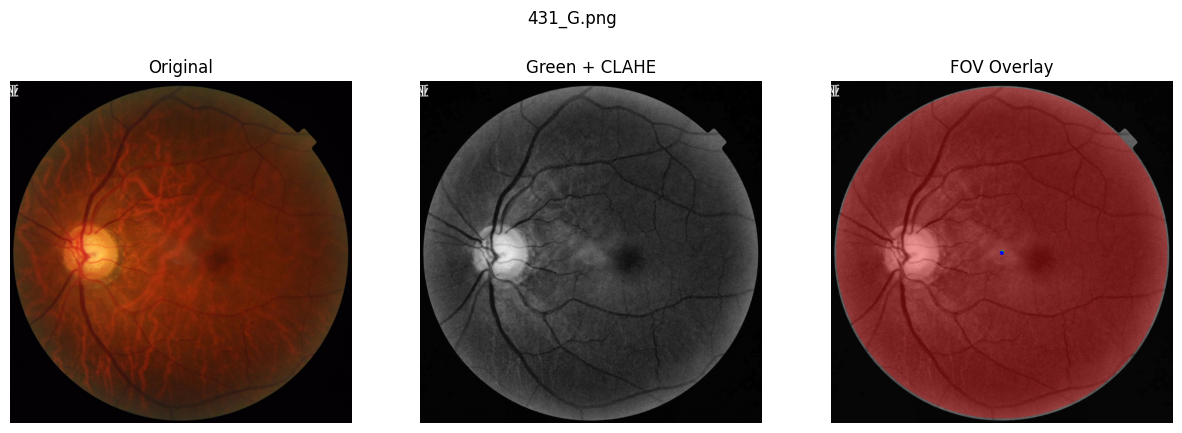

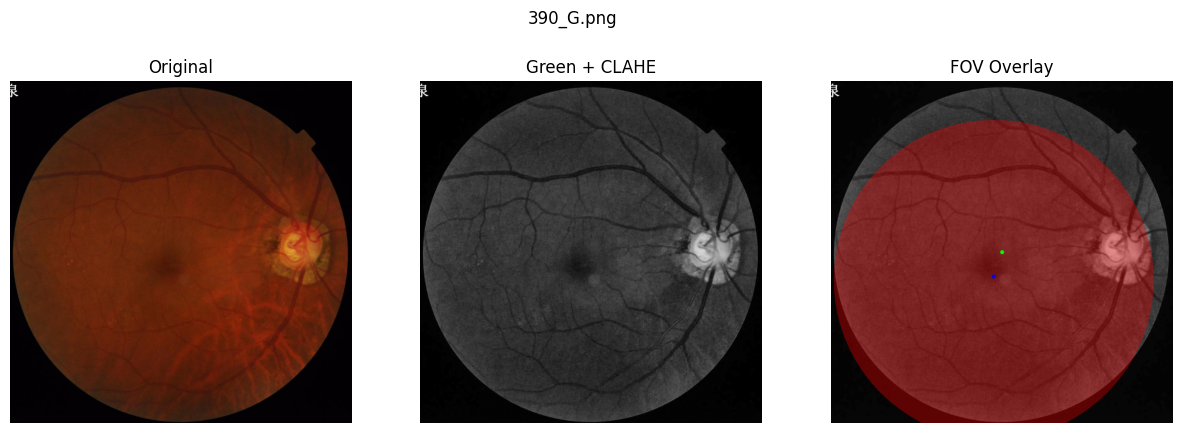

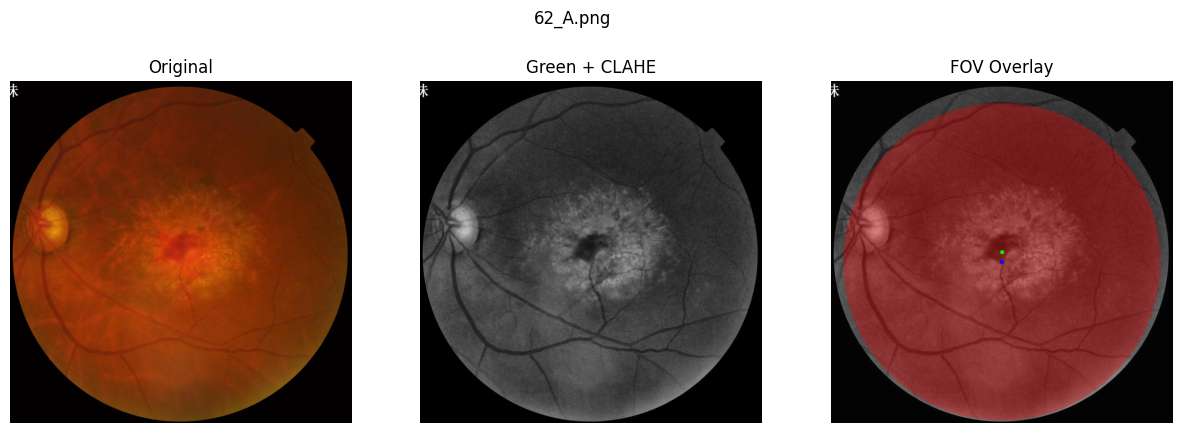

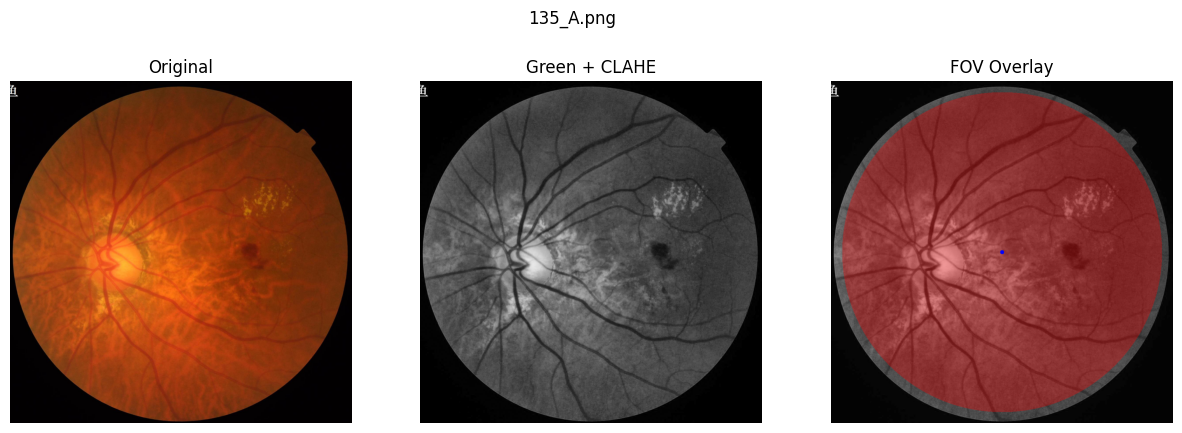

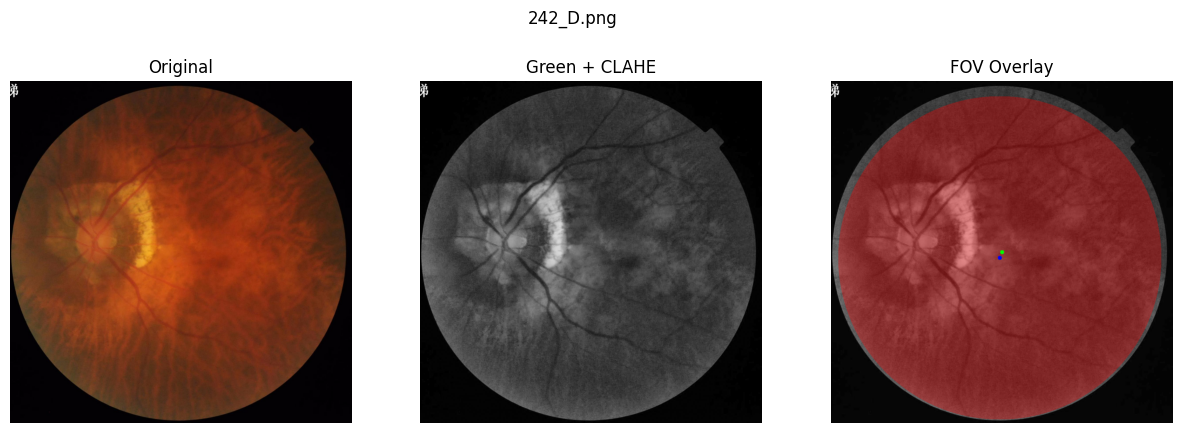

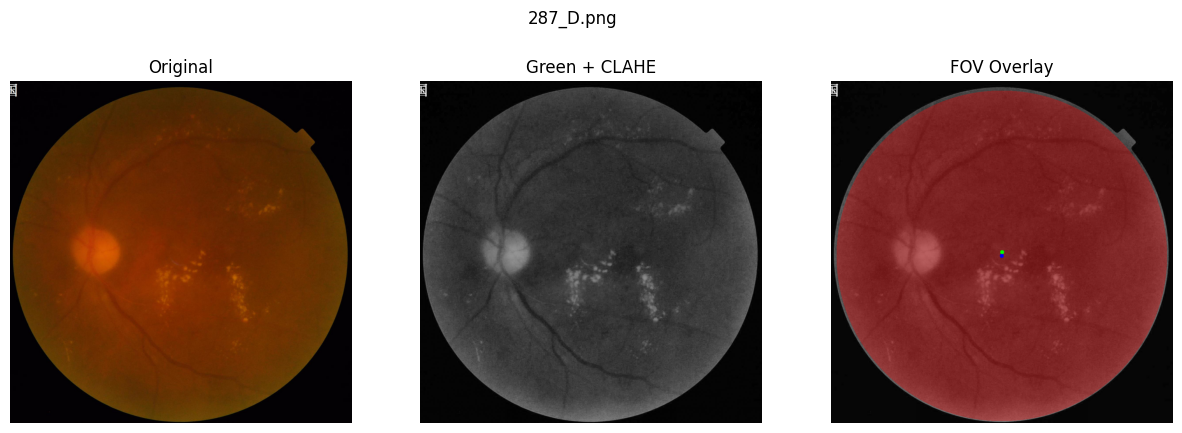

In [5]:
# Visualize a few triplets
for p in S:
    if img_dir.exists():
        proc = cv2.imread(str(p), cv2.IMREAD_GRAYSCALE)

        # Load the true original if available; else fallback to gray->BGR
        raw_bgr_path = RAW_DATASET / DATASET_SPLIT / 'Original' / p.name
        if raw_bgr_path.exists():
            bgr = cv2.imread(str(raw_bgr_path), cv2.IMREAD_COLOR)  # TRUE original
        else:
            bgr = cv2.cvtColor(proc, cv2.COLOR_GRAY2BGR)  # fallback

        msk_path = msk_dir / (p.stem + '.png')
        msk = cv2.imread(str(msk_path), cv2.IMREAD_GRAYSCALE)
        if msk is None:
            # rebuild from processed image if missing
            msk = make_fov_mask(proc, shrink_px=SHRINK_PX, bg_pct=BG_PERCENTILE, min_bg_area_ratio=MIN_BG_RATIO)
            msk = adjust_mask_area(msk, target=AREA_TARGET, tol=AREA_TOL, shrink_px=SHRINK_PX, r_bounds=R_BOUNDS)
    else:
        bgr  = cv2.imread(str(p), cv2.IMREAD_COLOR)
        proc = to_green_clahe(bgr)
        msk  = make_fov_mask(proc, shrink_px=SHRINK_PX, bg_pct=BG_PERCENTILE, min_bg_area_ratio=MIN_BG_RATIO)
        msk  = adjust_mask_area(msk, target=AREA_TARGET, tol=AREA_TOL, shrink_px=SHRINK_PX, r_bounds=R_BOUNDS)
    show_triplet(bgr, proc, msk, title=p.name)

In [6]:
# Quick area-ratio stats on the sample
ratios = []
for p in S:
    if img_dir.exists():
        msk_path = msk_dir / (p.stem + '.png')
        msk = cv2.imread(str(msk_path), cv2.IMREAD_GRAYSCALE)
        if msk is None:
            img = cv2.imread(str(p), cv2.IMREAD_GRAYSCALE)
            msk = make_fov_mask(img, shrink_px=SHRINK_PX, bg_pct=BG_PERCENTILE, min_bg_area_ratio=MIN_BG_RATIO)
            msk = adjust_mask_area(msk, target=AREA_TARGET, tol=AREA_TOL, shrink_px=SHRINK_PX, r_bounds=R_BOUNDS)
    else:
        bgr  = cv2.imread(str(p), cv2.IMREAD_COLOR)
        img  = to_green_clahe(bgr)
        msk  = make_fov_mask(img, shrink_px=SHRINK_PX, bg_pct=BG_PERCENTILE, min_bg_area_ratio=MIN_BG_RATIO)
        msk  = adjust_mask_area(msk, target=AREA_TARGET, tol=AREA_TOL, shrink_px=SHRINK_PX, r_bounds=R_BOUNDS)
    h, w = msk.shape
    ratios.append((msk > 0).sum() / float(h*w))

ratios = np.array(ratios)
print(f"Sample n={len(ratios)} | mean={ratios.mean():.3f} | std={ratios.std():.3f} | min={ratios.min():.3f} | max={ratios.max():.3f}")

Sample n=6 | mean=0.701 | std=0.026 | min=0.673 | max=0.737
